# Group 9
# Saba Janamian, Yuping Yu
# DSE 203 Final Project - Common Vulnerability and Exposure Analysis

In [78]:
import os
import json
from neo4j import GraphDatabase
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Connecting to Neo4j API

In [79]:
uri = "neo4j://localhost:7687"
userName = "neo4j"
password = "password"

In [80]:
# Connect to the neo4j database server
graph_db_driver  = GraphDatabase.driver(uri, auth=(userName, password))

In [81]:
base_dir = '/Users/janamian/Documents/workstation/ucsd_dse_program/fall_2019/docker_vol/saba-ja/workstation/dse_203_2020/project/dse_203_final_project_fall_2020/data'

In [82]:
with open(os.path.join(base_dir, 'cwe_data', 'cwec_v4.2.json')) as f:
    cwe = json.load(f)
    
# with open(os.path.join(base_dir, 'nvd_data', 'nvdcve-1.1-2020.json')) as f:
#     nvd = json.load(f)

# Count types

In [83]:
cwe_type_counter = {}
for obj in cwe['Weakness_Catalog']['Weaknesses']['Weakness']:
    for key, val in obj.items():
        t = cwe_type_counter.get(key, 0)
        if t == 0:
            cwe_type_counter[key] = 1
        else:
            cwe_type_counter[key] = cwe_type_counter[key] + 1

In [84]:
cwe_type_counter

{'@ID': 914,
 '@Name': 914,
 '@Abstraction': 914,
 '@Structure': 914,
 '@Status': 914,
 'Description': 914,
 'Extended_Description': 650,
 'Related_Weaknesses': 882,
 'Applicable_Platforms': 666,
 'Background_Details': 44,
 'Modes_Of_Introduction': 776,
 'Likelihood_Of_Exploit': 187,
 'Common_Consequences': 870,
 'Potential_Mitigations': 614,
 'Demonstrative_Examples': 475,
 'Observed_Examples': 392,
 'References': 496,
 'Content_History': 914,
 'Weakness_Ordinalities': 256,
 'Alternate_Terms': 83,
 'Detection_Methods': 89,
 'Taxonomy_Mappings': 628,
 'Related_Attack_Patterns': 273,
 'Notes': 313,
 'Affected_Resources': 51,
 'Functional_Areas': 24}

In [85]:
data = {'attribute_element':[], 'count':[]}
for key, value in cwe_type_counter.items():
#     if '@' not in key:
    data['attribute_element'].append(key)
    data['count'].append(value)
    
cwe_type_df = pd.DataFrame(data)
cwe_type_df.sort_values(by=['count'], ascending=False, inplace=True)
cwe_type_df.reset_index(drop=True, inplace=True)

In [86]:
cwe_type_df

,attribute_element,count
0,@ID,914
1,@Name,914
2,@Abstraction,914
3,@Structure,914
4,@Status,914
5,Description,914
6,Content_History,914
7,Related_Weaknesses,882
8,Common_Consequences,870
9,Modes_Of_Introduction,776


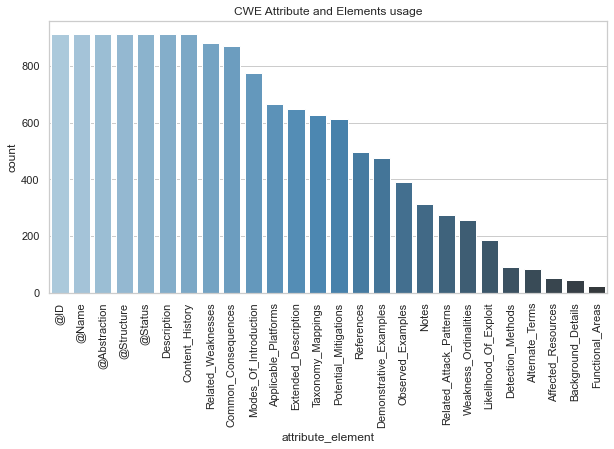

In [87]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="attribute_element", y="count", palette="Blues_d", data=cwe_type_df);
plt.title('CWE Attribute and Elements usage')
plt.setp(ax.get_xticklabels(), rotation=90);

In [88]:
def run_query(q):
    with graph_db_driver.session() as graph_db_session:
        try:
            graph_db_session.run(q)
        except:
            print(q)
            raise NameError

In [89]:
def get_cwe_name_by_id(cwe_id_val):
    for obj in cwe['Weakness_Catalog']['Weaknesses']['Weakness']:
        cwe_id = obj['@ID']
        if int(cwe_id) == int(cwe_id_val):
            return obj['@Name']

# Create CWE nodes and properties

In [90]:
# ####################
# Create CWE nodes and properties
# ####################
delete_query = 'MATCH (n) DETACH DELETE n'
run_query(delete_query)
for obj in cwe['Weakness_Catalog']['Weaknesses']['Weakness']:
    cwe_id = obj['@ID']
    name = obj['@Name'].replace('\\','\\\\').replace('"', '\\"').replace("'", "\\'")
    desc = obj['Description'].replace('\\','\\\\').replace('"', '\\"').replace("'", "\\'")
    likelihood_of_exploit = obj.get('Likelihood_Of_Exploit', 'Unknown')
    if likelihood_of_exploit == "Unknown":
        community = 0
    elif likelihood_of_exploit == "Low":
        community = 1
    elif likelihood_of_exploit == "Medium":
        community = 2
    elif likelihood_of_exploit == "High":
        community = 3
    else:
        print(cwe_id, likelihood_of_exploit)
    
    cql_create_cwe_node = f"""CREATE (:cwe {{ cwe_id: "{cwe_id}", 
    name: "{name}", 
    description: "{desc}",
    community: {community},
    likelihood_of_exploit: "{likelihood_of_exploit}"
    }})"""
    run_query(cql_create_cwe_node)

In [91]:
cql_create_cwe_node = f"""CREATE (:cwe {{ cwe_id: "NVD-CWE-Other", 
    name: "Other", 
    description: "NVD is only using a subset of CWE for mapping instead of the entire CWE, and the weakness type is not covered by that subset.",
    community: 0,
    likelihood_of_exploit: "Unknown"
    }})"""
run_query(cql_create_cwe_node)

In [92]:
cql_create_cwe_node = f"""CREATE (:cwe {{ cwe_id: "NVD-CWE-noinfo", 
    name: "Insufficient Information", 
    description: "There is insufficient information about the issue to classify it; details are unkown or unspecified.",
    community: 0,
    likelihood_of_exploit: "Unknown"
    }})"""
run_query(cql_create_cwe_node)

In [93]:
cql_create_cwe_node = f"""CREATE (:cwe {{ cwe_id: "NVD-no-analysis", 
    name: "No Analysis", 
    description: "CVEs mapping to this CWE are either rejected or do not have any mapping to any CWE",
    community: 0,
    likelihood_of_exploit: "Unknown"
    }})"""
run_query(cql_create_cwe_node)

# Create CWE weakness relationship

In [94]:
# ####################
# Create CWE weakness relationship
# ####################
relationship_set = set()
relationship_count = {}
for obj in cwe['Weakness_Catalog']['Weaknesses']['Weakness']:
    cwe_id = obj['@ID']
    name = obj['@Name']
    try:
        rel_obj = obj['Related_Weaknesses']['Related_Weakness']
    except KeyError:
        print(f'{cwe_id} has no outward weakness relationship. Name: {name}')
        continue
        
    if not isinstance(rel_obj, list):
        rel_obj_list = [rel_obj]
    else:
        rel_obj_list = rel_obj

    for rel in rel_obj_list:
        related_cwe_id = rel['@CWE_ID']
        relationship = rel['@Nature']
        rel_str = f'({cwe_id})->[{relationship}]->({related_cwe_id})'
        if rel_str in relationship_set:
            continue
        else:
            relationship_set.add(rel_str)
        
        if relationship == 'ChildOf':
            child_count = relationship_count.get(related_cwe_id, 0)
            child_count += 1
            relationship_count[related_cwe_id] = child_count
        
        cql_create_relationship = f"""MATCH (cwe1:cwe),(cwe2:cwe)
                                      WHERE cwe1.cwe_id = '{cwe_id}' AND cwe2.cwe_id = '{related_cwe_id}'
                                      CREATE (cwe1)-[r:{relationship}]->(cwe2)
                                      RETURN type(r)"""
        run_query(cql_create_relationship)
        
for key, val in relationship_count.items():
    cql_update_cwe_node = f"""MATCH (c:cwe {{ cwe_id: "{key}"}}) SET c.child_count = {val}"""
    run_query(cql_update_cwe_node)

1187 has no outward weakness relationship. Name: DEPRECATED: Use of Uninitialized Resource
132 has no outward weakness relationship. Name: DEPRECATED (Duplicate): Miscalculated Null Termination
216 has no outward weakness relationship. Name: DEPRECATED: Containment Errors (Container Errors)
217 has no outward weakness relationship. Name: DEPRECATED: Failure to Protect Stored Data from Modification
218 has no outward weakness relationship. Name: DEPRECATED (Duplicate): Failure to provide confidentiality for stored data
225 has no outward weakness relationship. Name: DEPRECATED (Duplicate): General Information Management Problems
247 has no outward weakness relationship. Name: DEPRECATED (Duplicate): Reliance on DNS Lookups in a Security Decision
249 has no outward weakness relationship. Name: DEPRECATED: Often Misused: Path Manipulation
284 has no outward weakness relationship. Name: Improper Access Control
292 has no outward weakness relationship. Name: DEPRECATED (Duplicate): Trusting

In [95]:
data = {'parent_id':[], 'parent_name': [], 'child_count':[]}
for key, value in relationship_count.items():
    data['parent_id'].append(key)
    p_name = get_cwe_name_by_id(key).split(' ')[0:6]
    p_name = ' '.join(p_name)
    p_name = f'{p_name} ({key})'
    data['parent_name'].append(p_name)
    data['child_count'].append(value)
    
cwe_child_count_df = pd.DataFrame(data)
cwe_child_count_df.sort_values(by=['child_count'], ascending=False, inplace=True)
cwe_child_count_df.reset_index(drop=True, inplace=True)
cwe_child_count_gt_n = cwe_child_count_df[cwe_child_count_df['child_count'] >= 20]
cwe_child_count_gt_n2 = cwe_child_count_df[cwe_child_count_df['child_count'] >= 10]
cwe_child_count_gt_n3 = cwe_child_count_df[cwe_child_count_df['child_count'] >= 5]

In [96]:
cwe_child_count_df

,parent_id,parent_name,child_count
0,710,Improper Adherence to Coding Standards (710),35
1,20,Improper Input Validation (20),34
2,664,Improper Control of a Resource Through (664),33
3,284,Improper Access Control (284),32
4,287,Improper Authentication (287),27
...,...,...,...
225,1286,Improper Validation of Syntactic Correctness o...,1
226,489,Active Debug Code (489),1
227,524,Use of Cache Containing Sensitive Information ...,1
228,1229,Creation of Emergent Resource (1229),1


In [97]:
cwe_child_count_gt_n

,parent_id,parent_name,child_count
0,710,Improper Adherence to Coding Standards (710),35
1,20,Improper Input Validation (20),34
2,664,Improper Control of a Resource Through (664),33
3,284,Improper Access Control (284),32
4,287,Improper Authentication (287),27
5,668,Exposure of Resource to Wrong Sphere (668),26
6,693,Protection Mechanism Failure (693),24
7,573,Improper Following of Specification by Caller ...,20


# Graph CWEs with more than 10 CWE children

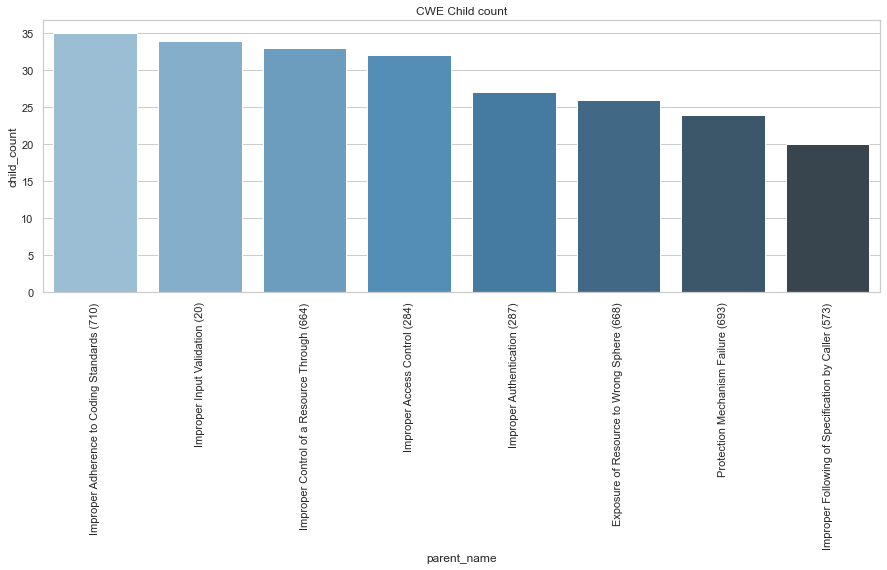

In [98]:
# ####################
# Graph CWEs with more than 10 CWE children
# ####################
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="parent_name", y="child_count", palette="Blues_d", data=cwe_child_count_gt_n, ci=None);
plt.title('CWE Child count')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=20)
plt.rc('figure', titlesize=15)

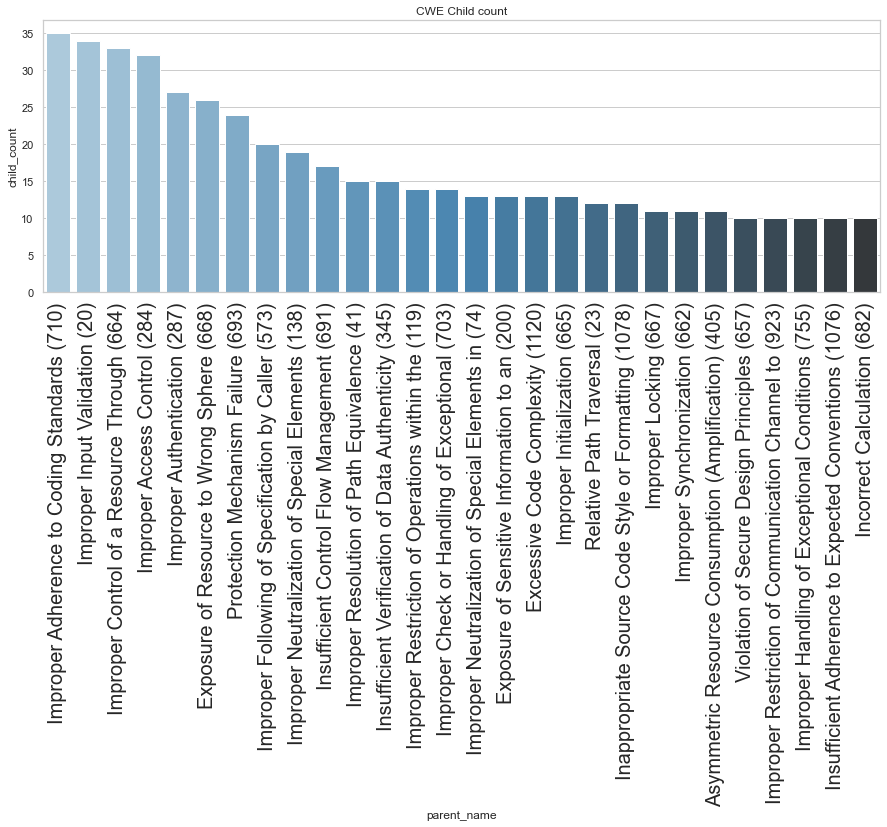

In [99]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="parent_name", y="child_count", palette="Blues_d", data=cwe_child_count_gt_n2, ci=None);
plt.title('CWE Child count')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)

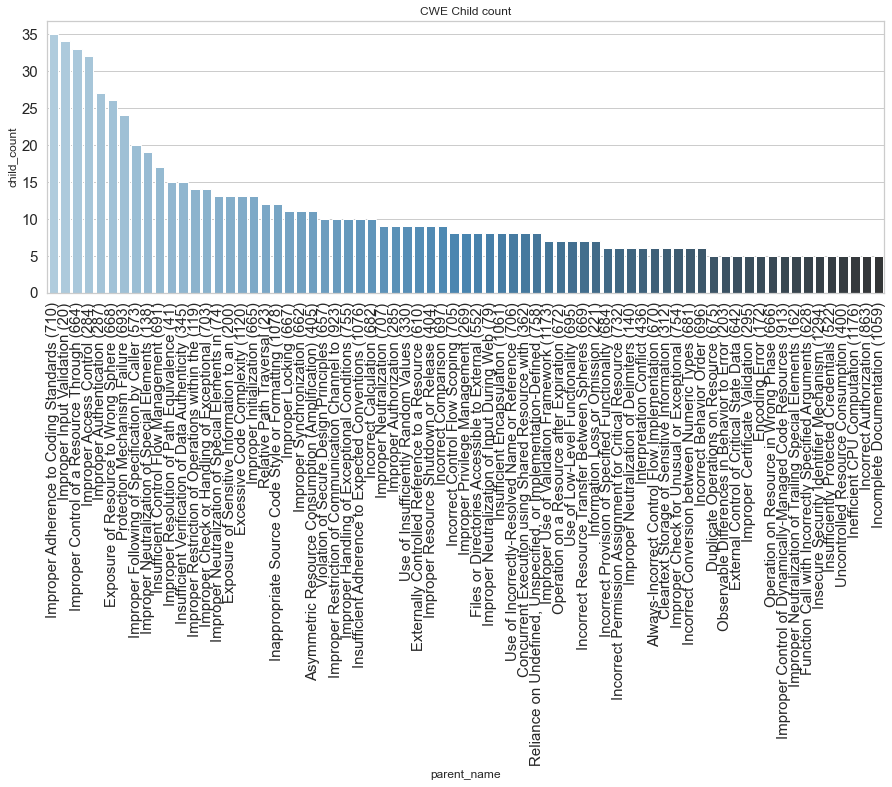

In [100]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="parent_name", y="child_count", palette="Blues_d", data=cwe_child_count_gt_n3, ci=None);
plt.title('CWE Child count')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)

# Create CWE Consequence Nodes

In [101]:
# ####################
# Create CWE Consequence Nodes
# ####################
def combine_lists(list_1, list_2):
    final_result = set()
    for val1 in list_1:
        for val2 in list_2:
            final_result.add(f'{val1}-{val2}')
    return list(final_result)
        

consquences_set = set()
cwe_consequence_list = {}
consquences_incomming_cwe_count = {}

for obj in cwe['Weakness_Catalog']['Weaknesses']['Weakness']:
    cwe_id = obj['@ID']
    
    try:
        consequences = obj['Common_Consequences']['Consequence']
    except KeyError:
#         print(f'{cwe_id} does not have consequence obj')
#         print('----') 
        continue
    
    if not isinstance(consequences, list):
        consequences_list = [consequences]
    else:
        consequences_list = consequences
    
    for cons in consequences_list:
        
        scope = cons.get('Scope', 'Unknown Scope')
        if not isinstance(scope, list):
            scope_list = [scope]
        else:
            scope_list = scope
            
        impact = cons.get('Impact', 'Unknown Impact')
        if not isinstance(impact, list):
            impact_list = [impact]
        else:
            impact_list = impact
            
        scope_impact_list = combine_lists(scope_list, impact_list)
        
        likelihood = cons.get('Likelihood', 'Unknown Likelihood')
        if not isinstance(likelihood, list):
            likelihood_list = [likelihood]
        else:
            likelihood_list = likelihood
            
        scope_impact_likelihood_list = combine_lists(scope_impact_list,likelihood_list)
        
        for val in scope_impact_likelihood_list:
            if val not in consquences_set:
                consquences_set.add(val)
                cql_create_cwe_consequence_node = f"""CREATE (:consequence {{ consequence_id: "{val}"}})"""
                run_query(cql_create_cwe_consequence_node)
        
            cwe_cons_list = cwe_consequence_list.get(cwe_id, [])
            if val not in cwe_cons_list:
                cql_create_relationship = f"""MATCH (cwe1:cwe), (consequence1: consequence)
                                      WHERE cwe1.cwe_id = '{cwe_id}' AND consequence1.consequence_id = '{val}'
                                      CREATE (cwe1)-[r:causes]->(consequence1)
                                      RETURN type(r)"""
                run_query(cql_create_relationship)
                cwe_cons_list.append(val)
                cwe_consequence_list[cwe_id] = cwe_cons_list
                count = consquences_incomming_cwe_count.get(val, 0)
                count += 1
                consquences_incomming_cwe_count[val] = count

In [102]:
for key,value in consquences_incomming_cwe_count.items():
    cql_update_cwe_node = f"""MATCH (c:consequence {{ consequence_id: "{key}"}}) SET c.child_count = {value}"""
    run_query(cql_update_cwe_node)

In [103]:
data = {'consequence_abbreviation': [], 'consequence_id':[], 'child_count':[]}
for key, value in consquences_incomming_cwe_count.items():
    cons_name = key.split('-')
    cons_name_abbr = f'{cons_name[0][:20]}-{cons_name[1][:20]}'
    
    data['consequence_abbreviation'].append(cons_name_abbr)
    data['consequence_id'].append(key)
    data['child_count'].append(value)
    
cwe_consequence_child_count_df = pd.DataFrame(data)
cwe_consequence_child_count_df.sort_values(by=['child_count'], ascending=False, inplace=True)
cwe_consequence_child_count_df.reset_index(drop=True, inplace=True)
cwe_consequence_child_count_df_gt_n = cwe_consequence_child_count_df[cwe_consequence_child_count_df['child_count'] >= 20]

In [104]:
cwe_consequence_child_count_df_gt_n

,consequence_abbreviation,consequence_id,child_count
0,Confidentiality-Read Application Dat,Confidentiality-Read Application Data-Unknown ...,179
1,Access Control-Bypass Protection Me,Access Control-Bypass Protection Mechanism-Unk...,145
2,Integrity-Execute Unauthorized,Integrity-Execute Unauthorized Code or Command...,127
3,Confidentiality-Execute Unauthorized,Confidentiality-Execute Unauthorized Code or C...,121
4,Availability-Execute Unauthorized,Availability-Execute Unauthorized Code or Comm...,119
5,Access Control-Gain Privileges or A,Access Control-Gain Privileges or Assume Ident...,113
6,"Availability-DoS: Crash, Exit, or","Availability-DoS: Crash, Exit, or Restart-Unkn...",101
7,Integrity-Modify Application D,Integrity-Modify Application Data-Unknown Like...,100
8,Integrity-Unexpected State,Integrity-Unexpected State-Unknown Likelihood,99
9,Other-Other,Other-Other-Unknown Likelihood,78


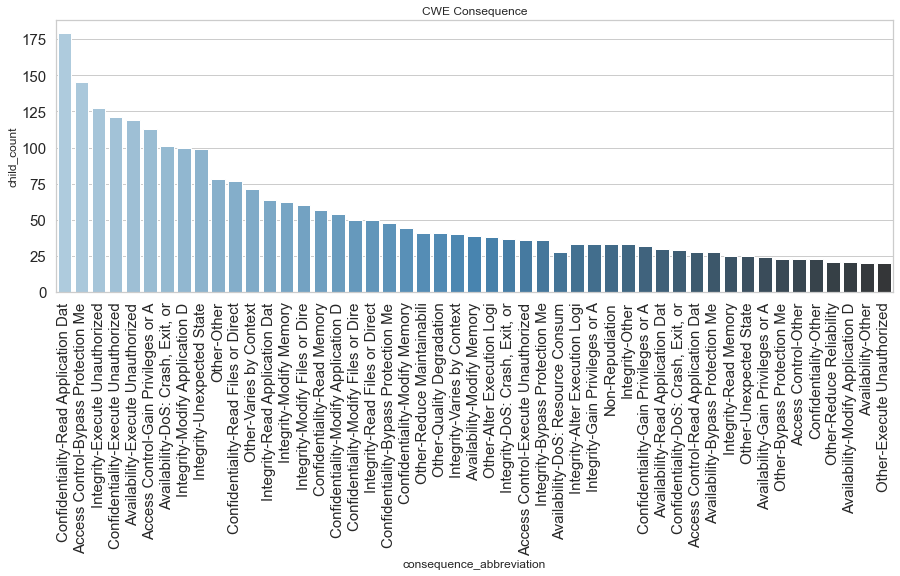

In [105]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="consequence_abbreviation", y="child_count", palette="Blues_d", data=cwe_consequence_child_count_df_gt_n, ci=None);
plt.title('CWE Consequence')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)

# Create CWE Mode of Introduction Nodes

In [106]:
# ####################
# Create CWE Mode of Introduction Nodes
# ####################
modes_of_intro_set = set()
modes_of_intro_cwe_list = {}
modes_of_intro_cwe_count = {}

for obj in cwe['Weakness_Catalog']['Weaknesses']['Weakness']:
    cwe_id = obj['@ID']
    try:
        modes_of_intro = obj['Modes_Of_Introduction']['Introduction']
    except KeyError:
#         print(f'{cwe_id} does not have modes_of_introduction')
        continue
        
    if not isinstance(modes_of_intro, list):
        modes_of_intro_list = [modes_of_intro]
    else:
        modes_of_intro_list = modes_of_intro
        
    for val in modes_of_intro_list:
        try:
            phase = val['Phase']
        except KeyError:
            continue
        except:
            print(val)
            raise ValueError
            
        if phase not in modes_of_intro_set:
            cql_create_cwe_modes_of_intro_node = f"""CREATE (:mode_of_introduction {{ mode_of_intro_id: "{phase}"}})"""
            run_query(cql_create_cwe_modes_of_intro_node)
            modes_of_intro_set.add(phase)

        
        modes_of_intro_cwe_val = modes_of_intro_cwe_list.get(cwe_id, [])
        if phase not in modes_of_intro_cwe_val:
            cql_create_relationship = f"""MATCH (cwe1:cwe), (intro1:mode_of_introduction)
                          WHERE cwe1.cwe_id = '{cwe_id}' AND intro1.mode_of_intro_id = '{phase}'
                          CREATE (cwe1)-[r:introduced_in]->(intro1)
                          RETURN type(r)"""
        
            run_query(cql_create_relationship)
            count = modes_of_intro_cwe_count.get(phase, 0)
            count += 1
            modes_of_intro_cwe_count[phase] = count
            modes_of_intro_cwe_val.append(phase)
            modes_of_intro_cwe_list[cwe_id] = modes_of_intro_cwe_val

In [107]:
for key,value in modes_of_intro_cwe_count.items():
    cql_update_cwe_node = f"""MATCH (c:mode_of_introduction {{ mode_of_intro_id: "{key}"}}) SET c.child_count = {value}"""
    run_query(cql_update_cwe_node)

In [108]:
data = {'mode_of_introduction':[], 'child_count':[]}
for key, value in modes_of_intro_cwe_count.items():
    data['mode_of_introduction'].append(f'{key} ({value})')
    data['child_count'].append(value)
    
modes_of_intro_cwe_count_df = pd.DataFrame(data)
modes_of_intro_cwe_count_df.sort_values(by=['child_count'], ascending=False, inplace=True)
modes_of_intro_cwe_count_df.reset_index(drop=True, inplace=True)

In [109]:
modes_of_intro_cwe_count_df

,mode_of_introduction,child_count
0,Implementation (694),694
1,Architecture and Design (438),438
2,Operation (101),101
3,Build and Compilation (4),4
4,Manufacturing (4),4
5,System Configuration (4),4
6,Integration (3),3
7,Requirements (3),3
8,Installation (3),3
9,Documentation (2),2


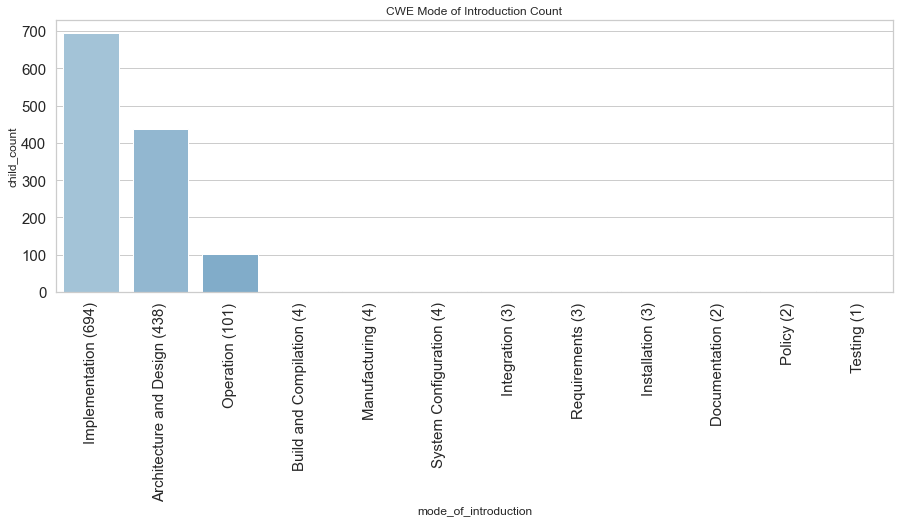

In [110]:
fig = plt.figure(figsize=(15,5))
ax = sns.barplot(x="mode_of_introduction", y="child_count", palette="Blues_d", data=modes_of_intro_cwe_count_df, ci=None);
plt.title('CWE Mode of Introduction Count')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)

# CWE Time series

In [111]:
# ####################
# CWE Time series
# ####################
data = {'cwe_id':[], 'cwe_name':[], 'submission_time':[]}

for obj in cwe['Weakness_Catalog']['Weaknesses']['Weakness']:
    cwe_id = obj['@ID']
    cwe_name = obj['@Name']
    submission_time = obj['Content_History']['Submission']['Submission_Date']
    submission_year = submission_time.split('-')[0]
    data['cwe_id'].append(cwe_id)
    data['cwe_name'].append(cwe_name)
    data['submission_time'].append(submission_year)

cwe_submission_time_df = pd.DataFrame(data)


In [112]:
cwe_submission_time_groupby = cwe_submission_time_df.groupby(by=['submission_time']).count().reset_index(drop=False)
cwe_submission_time_groupby.rename({'cwe_id':'submission_count'},axis='columns', inplace=True)
filtered_df = cwe_submission_time_groupby[cwe_submission_time_groupby['submission_count'] < 200]

In [113]:
filtered_df['submission_count'].describe()

count    12.000000
mean     31.750000
std      30.115309
min       4.000000
25%       9.500000
50%      20.000000
75%      49.750000
max      94.000000
Name: submission_count, dtype: float64

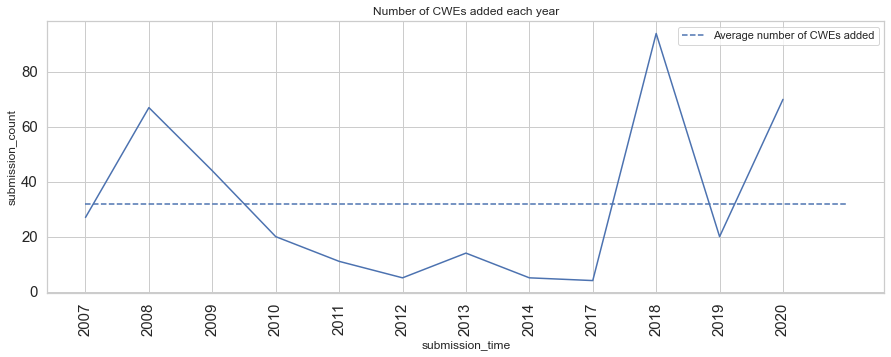

In [114]:
fig = plt.figure(figsize=(15,5))
ax = sns.lineplot(data=filtered_df, x="submission_time", y="submission_count");
plt.hlines(y=32, xmin=0, xmax=12, colors='b', linestyles='--', label='Average number of CWEs added')
plt.title('Number of CWEs added each year')
plt.setp(ax.get_xticklabels(), rotation=90);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('figure', titlesize=15)
ax.legend();

In [115]:
cwe_submission_time_groupby

,submission_time,submission_count,cwe_name
0,2006,533,533
1,2007,27,27
2,2008,67,67
3,2009,44,44
4,2010,20,20
5,2011,11,11
6,2012,5,5
7,2013,14,14
8,2014,5,5
9,2017,4,4
